# A Primer on Vector Autoregressions
### Miguel C. Herculano
#### miguelcbherculano@gmail.com
### Overview

The goal of this notebook is to encourage the use of Vector Autoregressions (VARs) by reducing the computational entry costs that preclude the deployment of VARs. The notebook guides the user through a VAR model Workflow that (we hope) can be used as a template for alternative applications. The intuition and key results behind much of the tools derived from Vector Autoregressions are briefly discussed. The interested reader may refer to the reference section for a suggestion of further reading. 

### Prerequisites

Installation of Matlab with an Econometrics Toolbox add-on. Follow the instructions in the [link](https://walczak.org/2017/07/using-matlab-in-jupyter-notebooks-on-windows/) to install a Matlab Kernel on your Jupyter Notebook. There is a companion file named `Primer_VAR.m` that can be open directly in Matlab. Please keep all the .m files in the same folder when running the notebook or `Primer_VAR.m`. 


### Table of Contents

* [1. Introduction](#1)
* [2. Data](#2)
* [3. What is a VAR? ](#3)
* [4. Structural Dynamic Analysis ](#4)
    * [4.1 Structural vs. reduced-form representation](#4.1)
    * [4.2 Identification Problem](#4.2)
        * [4.2.1 How to solve the identification problem ?](#4.2.1)
    * [4.3 Impulse Response Analysis](#4.3) 
    * [4.4 Forecast Error Variance Decomposition (FEVD)](#4.3)
    * [4.5 Historical Decomposition](#4.3)
* [5. Forecasting with VARs](#4)    
* [6. Footnotes](#6)
* [7. References](#7)

### 1. Introduction  <a class="anchor" id="1"></a>

In the 1980s, Christopher Sims (1980) introduced what would become one of the most popular tools used by applied macroeconomists - Vector Autoregressive Models, that owe their popularity to their many potential applications in macroeconomics. In the words of Stock and Watson (2001), "*macroeconometricians do four things: describe and summarize macroeconomic data, make macroeconomic forecasts, quantify what we do or do not know about the true structure of the macroeconomy, and advise (and sometimes become) macroeconomic policymakers.*" Below we show how VAR models can be deployed to do all four tasks. Section 2 starts with the first task: organizing and preparing the data. Section 3 provides a very brief introduction to Vector Autoregressions. Section 4 discusses the difference between reduced-form and structural representations of a Vector Autoregression. It also provides an intuition (and code to estimate) some of the most popular tools derived from VARs to conduct structural analysis - Impulse Response Functions, Forecast Error Variance Decomposition and Historical Decomposition. Section 5 discusses the use of Vector Autoregressions for macroeconomic forecasting.  

### 2 Data  <a class="anchor" id="2"></a>

Let us start with a macroeconometrician's first task - to describe and summarize macroeconomic data. 

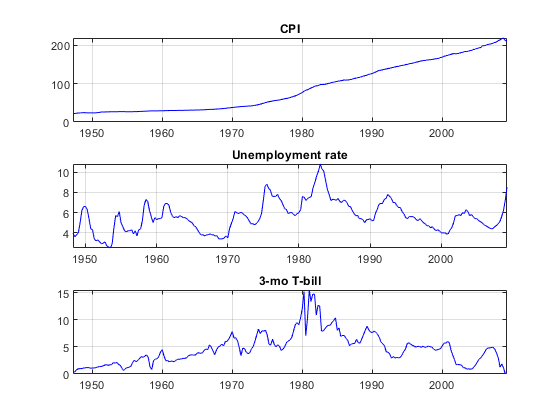

In [10]:
% First load the data
load 'Data_USEconModel'

% Plot the time-series
figure
subplot(3,1,1)
plot(DataTable.Time,DataTable.CPIAUCSL,'b');
title('CPI')
grid on
subplot(3,1,2);
plot(DataTable.Time,DataTable.UNRATE,'b');
title('Unemployment rate')
grid on
subplot(3,1,3);
plot(DataTable.Time,DataTable.TB3MS,'b')
title('3-mo T-bill')
grid on

The file `Data_USEconModel` is included in Matlab's Econometrics Toolbox. However, the data may also be downloaded from the [Federal Reserve Bank of St. Louis Economics Data (FRED)](https://fred.stlouisfed.org/) database. This notebook uses three of the time series: CPI (`CPIAUCSL`), Unemployment Rate (`UNRATE`) and the 3-month T-bill rate (`TB3MS`) so as to follow the work in Stock and Watson (2001). Note that the CPI is an index (1982-84=100) which measures the average monthly change in the price for goods and services in the US economy. The unemployment rate represents the number of unemployed as a percentage of the labor force. The 3-month T-bill rate is the secondary market yield on short-term US government debt and is our bechmark for the interest rate.

Plotting the data is important because it is necessary to make sure that the data is stationary (this is a key assumption of a VAR as we will see next). Trends and bouts of volatility are common features of macroeconomic data that violate this assumption. In this particular case, CPI appears to grow exponentially. Whereas, the `TB3MS` seems to trend upwards until the 1980s and downwards thereafter.  To counter the trends in CPI, we can simply take a difference of the logarithms of the data - by doing so, we measure inflation (the growth rate of CPI). With regards to the time-series of the interest rate, it is best to take the first-difference - notice that, although we do not encounter such an issue, interest rates may even be negative, in which case it would not be possible to take logs.

In [11]:
cpi_inf = price2ret(DataTable.CPIAUCSL); % dif-log
%irate = diff(DataTable.TB3MS); % 1st dif

% notice that by taking dif-log/dif we loose 1 observation and therefore UNRATE which is in levels needs to be adjusted
urate = DataTable.UNRATE(2:end,:); 
irate = DataTable.TB3MS(2:end,:); 

% now put the three variables together in an array called 'Data'
Data = array2timetable([cpi_inf urate irate],...
    'RowTimes',DataTable.Time(2:end),'VariableNames',{'CPI_Inf' 'U_Rate' 'Int_rate'});
    
% standardize variables
 y = standardize_miss(Data{:,1:3});
% store mean and std. for later re-scaling
m_y = nanmean(Data{:,1:3});
s_y = nanstd(Data{:,1:3});

% finally remove all missing values from the begginning of the sample
idx = all(~ismissing(y),2);
y = y(idx,:);

One last note about data transformation is in order. Notice that we have standardized our time-series. This means that their units are now interpreted simply as number of standard-deviation changes. This will be important when interpreting impulse-response functions later. Notice that it is trivial to revert this operation by 'un-standardizing' any statistic post-estimation. 



### 3. What is a Vector Autoregression (VAR) ?  <a class="anchor" id="3"></a>

A vector autoregression (VAR) is a multivariate time series model consisting of $n$ stationary variables, which are expressed as linear functions of their own lags. Thus, a VAR(p) includes $p$ own lags of each time-series considered . More formally, let $y_t = (y_{1t},...,y_{nt}  )' $, be a vector of time-series observed for $t=1,...,T$ and assume all variables in $y_t$ are covariance stationary - which implies: 

*  $E[y_{it}] = \mu_i$, constant mean ; 
* $V(y_{it}) = \sigma^2_i$, constant variance, and 
* $Cov(y_{i,t},x_{i,t+k})= \gamma_i(k)$, constant autocovariance. 

Under these assumptions, a structural VAR of order 1 is given by


$$
\begin{align}
y_t = \Phi y_{t-1} + B \varepsilon_t  \tag{1}
\end{align}
$$


where $\Phi$ and $B$ are $n \times n$ matrices of coefficients and $\varepsilon_t$ is a $n \times 1$ vector of zero-mean white-noise innovations. You may wonder why is equation (1) written for $p=1$. It turns out that this comes with no loss of generality because, any VAR(p) may be written in VAR(1) form (see Hamilton, 1994 and Lütkepohl, 2005 for further details and for a more comprehensive introduction to VARs). 

### 4. Structural Dynamic Analysis <a class="anchor" id="4"></a>

### 4.1 Structural vs. reduced-form representation <a class="anchor" id="4.1"></a>

Though we were silent about it, we wrote the VAR in equation (1) in structural form - what does this mean ? A structural VAR can be thought of as a representation of the underlying structure of an economy. In a structural VAR the innovations have a well-defined economic interpretation (for instance, monetary policy shocks, TFP shocks, demand and supply shocks etc.). The key idea is that structural shocks are orthogonal - because we assumed $\varepsilon_t \sim N(0,I_n)$ and therefore, we can focus on the causal effect of one shock at a time. For instance, we can study the macroeconomic consequences of monetary policy shocks abstracting from all the other shocks hitting the economy.

Unfortunately, the job of the macroeconometrician is never that easy. At the heart of structural VARs there is an identification issue that needs solving before we can make claims about causality of the diverse shocks in our representation of the economy. To understand the nature of this difficulty, let us write the three variable VAR in Stock and Watson (2001) in matrix form as follows

$$
\begin{bmatrix} 
\pi_t  \\ u_t   \\ r_t 
\end{bmatrix}
= 
\begin{bmatrix} 
\phi_{11} & \phi_{12} & \phi_{13}  \\ \phi_{21} & \phi_{22} & \phi_{23}    \\ \phi_{31} & \phi_{32} & \phi_{33}  
\end{bmatrix}
\begin{bmatrix} 
\pi_{t-1}  \\ u_{t-1}   \\ r_{t-1} 
\end{bmatrix}
+
\begin{bmatrix} 
b_{11} & b_{12} & b_{13}  \\ b_{21} & b_{22} & b_{23}    \\ b_{31} & b_{32} & b_{33}  
\end{bmatrix}
\begin{bmatrix} 
\varepsilon^{\pi}_t  \\ \varepsilon^{u}_t   \\ \varepsilon^{r}_t 
\end{bmatrix} \tag{2}
$$

The variables included in the VAR are inflation, unemployment and interest rate. The dynamic matrix $\Phi$ allows us to trace the dynamic effects of each shock over time; while the impact matrix $B$ maps the structural shocks, which are unobserved, to the reduced form shocks which can be estimated by OLS. For instance, $b_{13}$ captures the effect, on impact, of a shock to interest rates on inflation. 

Before proceeding, it is important to notice that, without further restrictions, system (2) cannot be estimated. However, its reduced form counterpart can - let us write it as follows

$$
y_t = \Phi y_{t-1} + u_t  \label{eq3}\tag{3}
$$

The reason why system (3) can be estimated is that the last element of (2) has been 'bundled' into $u_t$. Let's take model (3) to the data

In [12]:
% construct a model with #series=3 and #lags=2. We will estimate the model with 2 lags. 
model = varm(3,2);
% estimate the model
[var_est,SE_est,logL1,E1] = estimate(model,y);

**Notes:** 
* `var_est` model object is the estimation output structure.
* `SE_est` structure contain the standard errors of the fitted models.
* `logL` values are the loglikelihoods of the fitted models, which you use to help select the best model.
* `E1` vectors are the residuals, which are the same size as the estimation data.
* Type `help` followed by either `varm` or `estimate` to learn more about different VAR specifications that matlab can estimate.

### 4.2 Identification Problem <a class="anchor" id="4.2"></a>

In its reduced form, a VAR is a mere statistical model with which one cannot uncover or make any claim about the 'true' structure of an economy. This is the nature of the identification problem of VARs that will be elaborated next. We have seen that the identification issue in VARs boils-down to mapping structural shocks onto reduced form innovations, which can be retrieved from the data or analytically, by finding $B$ such that

$$
u_t = B \varepsilon_t. \tag{4}
$$

With this identity, we can write

$$
    \Sigma_u = \mathbb{E}(u_t'u_t) = \mathbb{E}[ B \varepsilon_t (B \varepsilon_t )']=B \mathbb{E} [\varepsilon_t \varepsilon_t '] B = B B' \tag{5}
$$

and therefore, identification is achieved if we find $B$ such that $\Sigma_u = B B'$. To see why identification in not straighforward, let us write (5) for the three-variable VAR of Stock and Watson(2001)

$$
\begin{bmatrix} 
\sigma_{11} & \sigma_{12} & \sigma_{13}  \\ - & \sigma_{22} & \sigma_{23}    \\ - & - & \sigma_{33}  
\end{bmatrix}
= 
\begin{bmatrix} 
b_{11} & b_{12} & b_{13}  \\ b_{21} & b_{22} & b_{23}    \\ b_{31} & b_{32} & b_{33}  
\end{bmatrix}
\begin{bmatrix} 
b_{11} & b_{12} & b_{13}  \\ b_{21} & b_{22} & b_{23}    \\ b_{31} & b_{32} & b_{33}  
\end{bmatrix}'. 
$$


Problem solved ? Not really, because the system of equations defined by (5) is indeterminate - notice that, because of the symmetry of the Variance-Covariance matrix $\Sigma_u$, there are more unknown elements on the right-hand side of equation (5). In other words, there are infinite $B$s that satisfy the equation above. 

#### 4.2.1 How to solve the identification problem ? <a class="anchor" id="4.2.1"></a>

One solution consists in imposing restrictions on $B$ based on economic theory. While a vast and growing literature discusses alternative identification schemes (i.e. alternative ways of finding the 'true' $B$), here we focus on the classic Cholesky identification strategy [<sup>1</sup>](#fn1). The Cholesky identification scheme consists in imposing zero (recursive) contemporaneous restrictions on $B$. Identification is achieved by assuming that some shocks have no effect on some endogenous variables on impact ( see Sims, 1980). How does this work out in practice ? Let us go back to our example in Stock and Watson (2001). In this context we impose the following restrictions  

$$
\begin{bmatrix} 
\sigma_{11} & \sigma_{12} & \sigma_{13}  \\ - & \sigma_{22} & \sigma_{23}    \\ - & - & \sigma_{33}  
\end{bmatrix}
= 
\begin{bmatrix} 
b_{11} & 0 & 0  \\ b_{21} & b_{22} & 0    \\ b_{31} & b_{32} & b_{33}  
\end{bmatrix}
\begin{bmatrix} 
b_{11} & 0 & 0  \\ b_{21} & b_{22} & 0   \\ b_{31} & b_{32} & b_{33}  
\end{bmatrix}'. \tag{6}
$$

Imposing $b_{12}=b_{13}=b_{23}=0$ allows us to narrow down $B$ to a single matrix $B^*$ that solves system (6) - notice that the number of unknown parameters in $\Sigma_u$ and $B^*$ is now equal. Nevertheless, it is important to remember the implication of imposing such assumptions. In the example above, we are assuming that inflation does not react contemporaneously to a shock to unemployment (i.e. $b_{12}=0$) and that a shock to interest rates has no effect on impact on inflation and unemployment (i.e. $b_{13}=b_{23}=0$). Notice that, these assumptions necessarily imply that the ordering of the endogenous variables considered in the VAR matters. In other words, inference in the model varies depending on whether one estimates a VAR on inflation, unemployment and interest rates as opposed to a different ordering, for instance, interest rates, inflation and unemployment. 

Computationally, we can find matrix $B$ by performing a simple calculation on the Variance-Covariance matrix which we already estimated above.

In [13]:
% recover the Variance-Covariance matrix Sigma from the VAR structure and perform a cholesky decomposition
Sigma = var_est.Covariance;
B_chol = chol(Sigma)'


B_chol =

    0.7190         0         0
   -0.0158    0.2382         0
    0.0792   -0.1110    0.2862




### 4.3 Impulse Response Analysis <a class="anchor" id="4.3"></a>

After identifying the structural shocks, VARs offer a number of tools to study the dynamic response of an economy to an innovation to a specific shock. Because the structural shocks are orthogonal, one can study how the endogenous variables in the VAR react to the change of a specific structural shock, keeping all the other shocks unchanged. Impulse responses allow us to examine the reaction of the economy, going forward, to a hypothetical change in one of the structural shocks. In Stock and Watson (2001) for instance, because the innovations to the interest rate equation are interpreted as Monetary Policy shocks, we can study how the economy behaves to a hypothetical change in the monetary policy stance. 

Before we see how to compute impulse responses from our VAR structure, let's go through the maths. Impulse response functions allow us to study the response of $y$ at times $\{t,t+1,...\}$ to a shock $\varepsilon$ at time t. Notice that the VAR in (3) can be written in MA($\infty$) form as

$$
(1-L \Phi)y_t = u_t \\
y_t = (1-L \Phi)^{-1}u_t \\
y_t = (\Phi L )^{0} u_t + (\Phi L )^{1} u_t + (\Phi L )^{2} u_t + ... \\
y_t = u_t + \Phi u_{t-1} + \Phi^2 u_{t-2} + ...
$$

Where $L$ defines a lag operator (i.e. $LX_t = X_{t-1}$, $L^{2}X_t = X_{t-2}$ and so forth). Next, plugging equation (4) into the above, we can write 

$$
y_t = B \varepsilon_t + \Phi B \varepsilon_{t-1} + \Phi^2 B \varepsilon_{t-2} + ... \tag{6}
$$

Equation (6) is the moving average representation of the VAR in equation (1), written in terms of the structural shocks process. It is very important because it allows us to derive the impulse response functions  

$$
\dfrac{\partial y_t}{\partial \varepsilon_t} = B, \dfrac{\partial y_{t+1}}{\partial \varepsilon_{t}} = \Phi B, ..., \dfrac{\partial y_{t+j}}{\partial \varepsilon_{t}} = \Phi^{j} B
$$

Impulse response functions (IRF) simply plot $\dfrac{\partial y_{t+j}}{\partial \varepsilon_{t}}$ for $j= \{1,...,H \}$. This function retrieves the response of variables $y_{t}$ to a unit shock to $\varepsilon_{t}$, $j$ periods after it hit the system. It is interesting to notice that IRFs depend on our identification strategy (which defines $B$) and on the coefficients matrix $\Phi$ stemming from the estimation of the reduced-form VAR. Let's see how to calculate IRFs in practice


ans =

         0
    0.0232
    0.0431
    0.0661




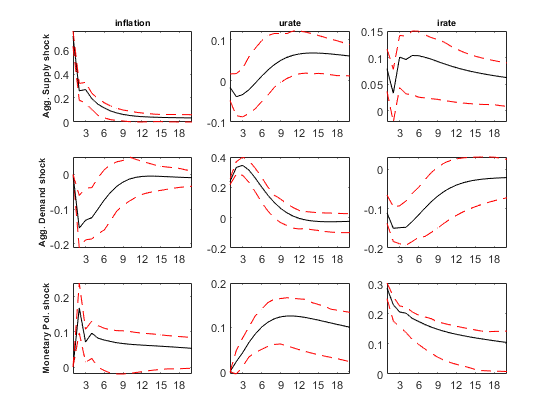

In [14]:
% "irf" below is a 3D tensor whose dimensions are (H,#var.shock,#var.response) 
[response,lower,upper] = irf(var_est);
% WARNING: give a different name to an output and a function - otherwise this will cause errors in the notebook.
% Now, for instance, let us examine the IRF of the urate wrt. a MP shock, for a 1 year horizon (1:4 quarters):
response(1:4,3,2)
% Next, plot the IRF for all shocks and all variables neatly
% start by defining some basic quatities
N = 3; % No. variables in the VAR
H = size(response,1); % Horizon of the IRF (by default matlab assumes H=20)
vnames = {'inflation','urate','irate'};
nshock = {'Agg. Supply shock','Agg. Demand shock','Monetary Pol. shock'};
mm = 1;
    for jj = 1:N %nshocks
        for ii = 1:N %nvars
                subplot(N,N,mm)
                plot(1:H,squeeze(lower(:,jj,ii)),'r--')
                hold on
                plot(1:H,squeeze(response(:,jj,ii)),'k-')
                hold on
                plot(1:H,squeeze(upper(:,jj,ii)),'r--')
                if jj==1 %&& jj==1
                    title(vnames(ii), 'FontSize', 7)
                end
                if ii==1 %&& jj==1
                    ylabel(nshock(jj), 'FontSize', 7, 'FontWeight','bold')
                end                
                %title('...')
                xlim([1 H])
                set(gca,'XTick',0:3:H)    
                mm = mm+1;
        end
    end

Matlab's `irf()` function allows for the calculation of confidence bands. In the above output, these confidence bands, stored in the objects 'lower' and 'upper', are calculated for a 95% confidence region through a bootstap procedure with 100 Monte Carlo replicas - these parameters are set by default but can be modified by the user. [<sup>2</sup>](#fn2)

### 4.4 Forecast Error Variance Decomposition <a class="anchor" id="4.4"></a>

What portion of the variance of the VAR's forecast errors, at a given horizon h, is due to a given structural shock in $\varepsilon_t$ ? This question can be answered by computing Forecast Error Variance Decomposition (FEVD) statistics. Let's start by writing the VAR's Forecast Error for a generic horizon $h$ [<sup id="fn3">3</sup>](#fn3-back)

$$
y_{t+h} - \mathbb{E}_{t-1}(y_{t+h}) = \sum_{k=0}^{h} \Phi^{h-k} B \varepsilon_{t+h-k} \tag{7}
$$

To verify the derivation of equation (7), see Lütkepohl(2005). Next, notice that the variance of the forecast errors are just their squares, since the mean forecast error is zero. Hence, it can be shown (see Sims, E., 2011) that the FEVD of variable $i$ due to shock $j$ at horizon $h$ is

$$
\omega_{ij}(h)= \sum^{h}_{k=0} C_{i,j}(k)^2
$$
where $C_{ij}(h) $ is the impulse response of variable $i$ to a shock $j$ at horizon $h$. Because it is more meaningful to think about the portion of the total FEVD due to shock $j$, it is often reported 

$$
\dfrac{\sum^{h}_{k=0} C_{i,j}(k)^2}{\sum^{h}_{k=0} \sum^{n}_{j=1} C_{i,j}(k)^2}
$$

Which is simply $\omega_{ij}(h)$ divided by the contribution of all shocks to the variance of the forecast error. Let's see how to get this in practice in our example.

In [15]:
% compute fevd get a 3D tensor
[decomp,decomp_lower,decomp_upper] = fevd(var_est);

% The fevd in element (t,i,j) is the contribution (in % terms) to the variance decomposition 
% of variable j attributable to an innovation shock to variable i at time t.
% Now get the fevd for inflation wrt. a Monetary Policy shock for h={1, 4, 8, 20} quarters.
decomp([1 4 8 20],3,1)



ans =

         0
    0.0534
    0.0735
    0.1137




### 4.5 Historical Decomposition <a class="anchor" id="4.5"></a>

Historical decompositions (HD), allows us to assess the historical contribution of each structural shock in driving each variable away from its long-run mean. The starting point is a representation of each endogenous variable included in the VAR as a sum of all the shocks in the system.  Let us write the Wold representation of the VAR in equation (1)

$$
y_t = \Phi^t y_0 + \sum^{t-1}_{i=0} \Phi^j B \varepsilon_{t-j}. \tag{8}
$$

Representing a VAR as a Moving-Average (MA) process as above is always possible subject to stationarity. [<sup>4</sup>](#fn4) Notice that Equation (8) expresses our time-series $y_t$ as a function of current and past shocks $\{\varepsilon_t,\varepsilon_{t-1},...  \}$. Thus, our exercise now is to desintangle the contribution of each shock to the dynamics of each series. Let's recycle our example with Stock and Watson (2001) data and see how this works in practice. 

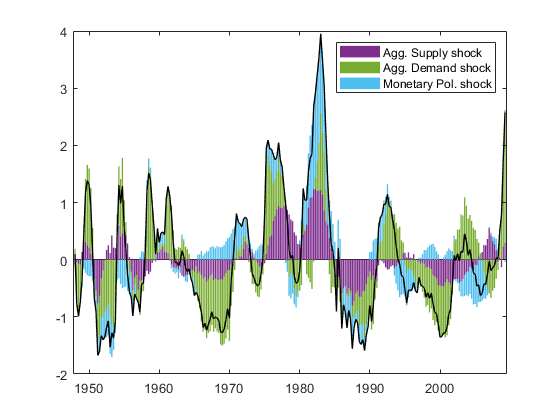

In [16]:
% define some quantities needed for the calculation
B = cell2mat( var_est.AR);
SIGMA = var_est.Covariance;
hor = 20; % 
% perform HD. - for a peek into the black box, open the function "HD" and see what is going on.
% Long story short: 1st - we write the VAR in MA form; 2nd - we explore the elements in C(L) to desintangle the contribution of 
HD_struct = HD(B,SIGMA,E1,hor,N);

% Now explore the structure and plot HD
% Note: hd(:,:,k) gives the decomposition of y_k due to e1,e2,e3,...
tt = Data.Time(3:end);
figure(1)
H1 = BarPlot(tt,HD_struct.hd_rec(:,:,2)');
hold on 
H2 = plot(tt, HD_struct.y_rec(2,:),'k','LineWidth',1);
legend('Agg. Supply shock','Agg. Demand shock','Monetary Pol. shock')


The graph above shows the HD of Unemployment (standardized). The coloured bars show the significance of each shock in driving fluctuations in Unemployment - recall that the structural shocks previously identified were Monetary Policy and two shocks akin to Aggregate Demand and Aggregate Supply (see Stock and Watson, 2001). 

### 5 Forecasting with VARs <a class="anchor" id="5"></a>

Forecasting is another important task for macroeconometricians and VARs have proven to be important tools in helping them with their job. Forecasting is quite different to structural analysis, which we have been discussing in the previous sections of this notebook. We are now mostly interested in accuracy and goodness of fit, in-sample and out-of-sample rather than in finding a theorethically sound mapping between the 'true' structure of the economy and reduced-form model representations. 

In a multivariate environment, forecasting involves making statements about the future path of $y_s$, given a model for the data generating process, for instance a VAR(1), and an information set $\Omega_T = \{y_s|s<T\}$. The forecast is made for a horizon $h$ that denotes the number of periods projected into the future; made at time $T$, up to which we observe the history of the process $y_s$. One of the key quantities of interest are point forecasts which can be thought of as the conditional expectation of $y_s$ at forecast origin $T$ for a forecast horizon $h$, written for our model in Equation (1) as 

$$
y_{T+h|T} := \mathbb{E}(y_{T+h}|\Omega_T) = \Phi y_{T+h-1}
$$

Notice that beyond time $T$ we do not observe $y$. Then, how do we obtain a point estimate for $y_{T+h}$ at time $T$ if we don't observe $y_{T+h-1}$ ? We may recursively construct the forecasts using the chain-rule of foresting. To see how, let us write

$$
y_{T+1|T} = \Phi y_{T} \\
y_{T+2|T} = \Phi y_{T+1} \\
... \\
y_{T+H|T} = \Phi y_{T+H-1}.
$$

Next, in the equations above, substitute $y_{T+h-1}$ with $y_{T+h-1|T}$ for all $h = \{1,...,H\}$.

Point estimates measure our expectation of how the time series will behave, beyond a certaint point in time. However, they are silent about how uncertain our estimate is. Uncertainty can be expressed through forecast errors. Let us write the h-step ahead forecast error as 

$$
 e_{h|T-1} := y_{T+h} - y_{T+h|T-1}= \sum_{k=0}^{h} \Phi^{h-k} u_{t+h-k} \tag{9}
$$

Because the expectation of the Forecast Error is nill, we can write the variance as 

$$
MSE(e_{h|T-1}) = \sum_{k=0}^{h} \Phi^{h-k} \Sigma_u  \Phi'^{h-k}
$$

Let's see how to perform forecasting in practice by recycling our reduced form VAR. In what follows we use a VAR(2) similar to the specification in Stock and Watson (2001) and forecast CPI inflation, Unemployment and Interest Rates from 2004Q2 onwards. 

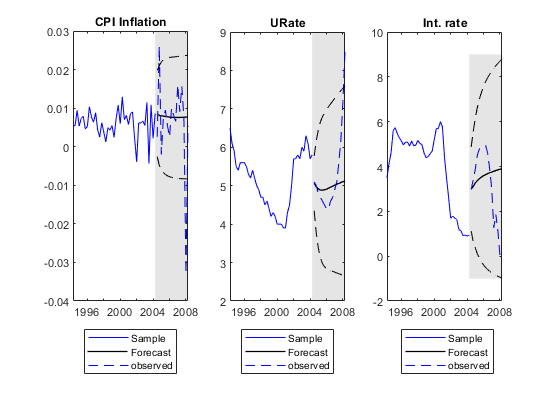

In [17]:
%% set forecast horizon
h = 16;
% save 16 observations for out-of-sample analysis
Y0 = y(1:end-16,:);
var_f = estimate(model,Y0);
% Forecast based on Y0
[Y_fore, YMSE] = forecast(var_f,h,Y0);

% Calculate confidence bands
extractMSE = @(x)diag(x)';
MSE = cellfun(extractMSE,YMSE,'UniformOutput',false);
SE = sqrt(cell2mat(MSE));
YFI = zeros(h,var_est.NumSeries,2);
YFI(:,:,1) = Y_fore - 2*SE;
YFI(:,:,2) = Y_fore + 2*SE;

% re-scale time-series and forecasts
y_scale = m_y + y.*s_y;
Y_fore_scale = m_y + Y_fore.*s_y;
YFI_scale = m_y + YFI.*s_y;
Y1 = y_scale(end-15:end,:);

% Now plot forecasts 
fh = dateshift(Data.Time(end-20),'end','quarter',1:h);
vnames = {'CPI Inflation' 'URate' 'Int. rate'};
figure;
for k=1:N
    subplot(1,N,k)
    h1 = plot(Data.Time(end-60:end-20),y_scale(end-60:end-20,k),'b');
    hold on;
    h2 = plot(fh,Y_fore_scale(:,k),'k','LineWidth',1);
    hold on 
    h3 =  plot(fh,Y1(:,k),'--b');
    hold on 
    h4 = plot(fh,YFI_scale(:,k,1),'k--');
    hold on
    h5 = plot(fh,YFI_scale(:,k,2),'k--');
    title(vnames{k});
    h = gca;
    fill([Data.Time(end-20) fh([end end]) Data.Time(end-20)],h.YLim([1 1 2 2]),'k',...
        'FaceAlpha',0.1,'EdgeColor','none');
    legend([h1 h2 h3],'Sample','Forecast','observed', 'Location', 'southoutside')
    hold off;
end

### 6. Footnotes <a class="anchor" id="6"></a>

[<sup id="fn1">1</sup>](#fn1-back) For a thorough discussion of alternative identification strategies, see Stock and Watson (2016), section 4 and Ramey (2016).

[<sup id="fn2">2</sup>](#fn2-back) Type `help irf` in a code cell in the notebook or in your matlab console to learn more.

[<sup id="fn3">3</sup>](#fn3-back) This section and the next follow extensively Cesa-Bianchi, A. (2021) available [Online](https://drive.google.com/file/d/14LA-q41ns364CtlkJYxF1h-JgCWM-HCy/view).

[<sup id="fn4">4</sup>](#fn4-back) To check stationarity for the VAR expressed as in Equation (1), check that the eigenvalues of $\Phi$ are less than 1 in modulus. In this case an MA representation is licit because invertibility is possible (see Lütkepohl, 2005 for more details). 


### 7. References <a class="anchor" id="7"></a>

[1] Cesa-Bianchi, A. (2021) Vector Autoregressions (VARs), Lecture Notes.

[2] Lütkepohl, Helmut (2005) New Introduction to Multiple Time Series Analysis. New York, NY: Springer-Verlag.

[3] Hamilton, James D. (1994) Time Series Analysis. Princeton, NJ: Princeton University Press.

[4] Sims, Christopher A. (1980) Macroeconomics and Reality. Econometrica. January, 48:1, pp. 1– 48.

[5] Sims, Eric (2011) Graduate Macro Theory II: Notes on Time Series, University of Notre Dame.

[6] Stock, James, H., and Mark W. Watson (2001) Vector Autoregressions. Journal of Economic Perspectives, 15 (4): 101-115. 

[7] Stock, James, H., and Mark W. Watson (2016) Factor Models and Structural Vector Autoregressions in Macroeconomics, Handbook of Macroeconomics, Vol. 2 (8), pp. 415-525.

[8] Ramey, Valerie A. (2016) Macroeconomic Shocks and Their Propagation, Handbook of Macroeconomics, Vol. 2 (2), pp.  71-162.